## Fine-tuning Stable Diffusion XL with DreamBooth and LoRA on a free-tier Colab Notebook 🧨

In this notebook, we show how to fine-tune [Stable Diffusion XL (SDXL)](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/stable_diffusion_xl) with [DreamBooth](https://huggingface.co/docs/diffusers/main/en/training/dreambooth) and [LoRA](https://huggingface.co/docs/diffusers/main/en/training/lora) on a T4 GPU.

SDXL consists of a much larger UNet and two text encoders that make the cross-attention context quite larger than the previous variants.

So, to pull this off, we will make use of several tricks such as gradient checkpointing, mixed-precision, and 8-bit Adam. So, hang tight and let's get started 🧪

## Setup 

In [14]:
# Check the GPU
!nvidia-smi

In [13]:
# Install dependencies.
!pip install bitsandbytes transformers accelerate peft -q

Make sure to install `diffusers` from `main`.

In [12]:
!pip install git+https://github.com/huggingface/diffusers.git -q

Download diffusers SDXL DreamBooth training script.

In [11]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

In [ ]:
from PIL import Image
import glob
import json
import locale


## Dataset

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Preview the images:

In [ ]:
def image_grid(imgs, rows, cols, resize_height=512, resize_width=512):

    if resize_height and resize_width is not None:
        imgs = [img.resize((resize_width, resize_height)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

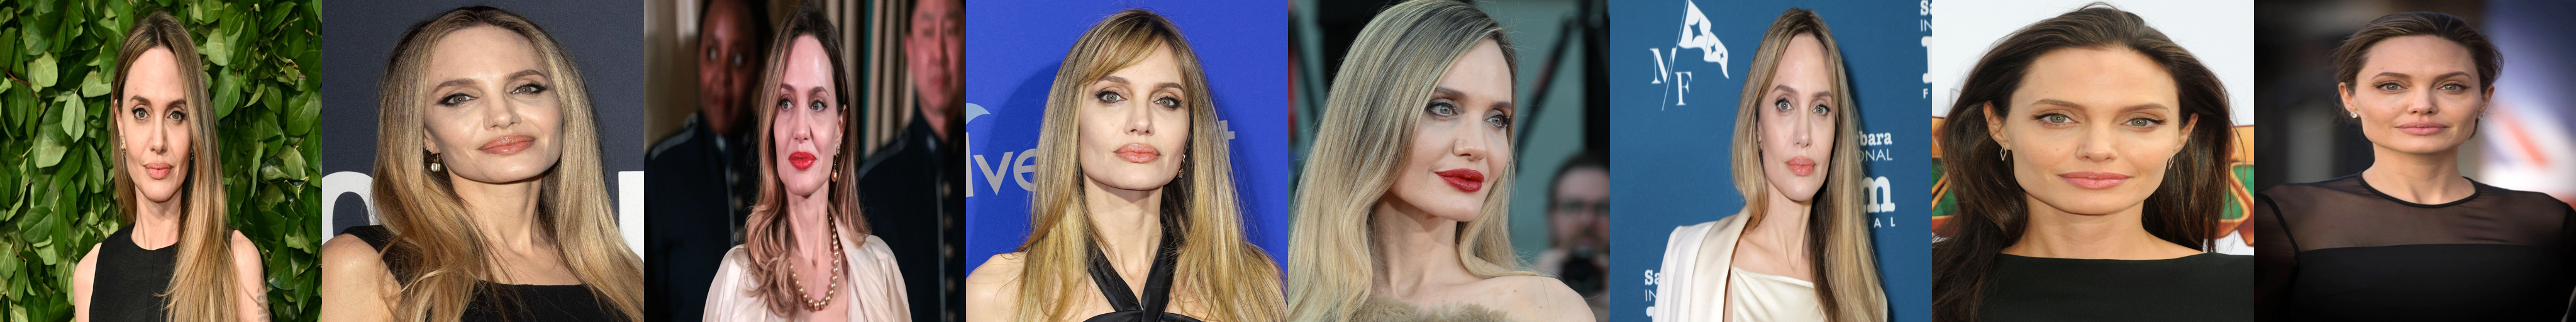

In [ ]:
img_paths = "/content/drive/My Drive/dataset/9/*.jpg"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 8
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

In [ ]:
# create a list of (Pil.Image, path) pairs
local_dir = "/content/drive/My Drive/dataset/9/"
imgs_and_paths = [(path, Image.open(path)) for path in glob.glob(f"{local_dir}*.jpg")]

Now let's add the concept token identifier (e.g. TOK) to each caption using a caption prefix.
Feel free to change the prefix according to the concept you're training on!
- for this example we can use "a photo of TOK," other options include:
    - For styles - "In the style of TOK"
    - For faces - "photo of a TOK person"
- You can add additional identifiers to the prefix that can help steer the model in the right direction.

In [ ]:
caption_prefix = "a photo of a TOK person" #@param
with open(f'{local_dir}metadata.jsonl', 'w') as outfile:
  for img in imgs_and_paths:
      caption = caption_prefix
      entry = {"file_name":img[0].split("/")[-1], "prompt": caption}
      json.dump(entry, outfile)
      outfile.write('\n')

## Prep for training 💻

Initialize `accelerate`:

In [9]:
locale.getpreferredencoding = lambda: "UTF-8"

!accelerate config default

## Train! 🔬

#### Set Hyperparameters ⚡
To ensure we can DreamBooth with LoRA on a heavy pipeline like Stable Diffusion XL, we're using:

* Gradient checkpointing (`--gradient_accumulation_steps`)
* 8-bit Adam (`--use_8bit_adam`)
* Mixed-precision training (`--mixed-precision="fp16"`)

### Launch training 🚀🚀🚀

 - Use `--output_dir` to specify your LoRA model repository name!
 - Use `--caption_column` to specify name of the cpation column in your dataset. In this example we used "prompt" to
 save our captions in the
 metadata file, change this according to your needs.

In [8]:
#!/usr/bin/env bash
!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="SG161222/RealVisXL_V5.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --instance_data_dir="/content/drive/My Drive/dataset/exp_9/9" \
  --output_dir="/content/drive/My Drive/dreambooth_outputs/exp_9.1" \
  --caption_column="prompt"\
  --mixed_precision="fp16" \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=3 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --max_train_steps=550 \
  --checkpointing_steps=717 \
  --seed="0"

## Inference 🐕

In [ ]:
import torch
from diffusers import DiffusionPipeline, AutoencoderKL

In [7]:
# Load VAE
vae = AutoencoderKL.from_pretrained(
    "madebyollin/sdxl-vae-fp16-fix",
    torch_dtype=torch.float16
)

# Load SDXL base model
pipe = DiffusionPipeline.from_pretrained(
    "SG161222/RealVisXL_V5.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)

# Load your trained LoRA weights from Google Drive
pipe.load_lora_weights("/content/drive/My Drive/dreambooth_outputs/exp_9.1")

# Move to GPU
pipe.to("cuda")

In [2]:
negative_prompt = "deformed, cripple, ugly, additional arms, additional legs, additional head, two heads, multiple people, group of people"
prompt = "image of TOK woman with a thoughtful expression, pure red background to emphasize facial details and create a mysterious vibe, realistic, UHD, rich detail"

images = []
for seed in range(1, 6):
    generator = torch.manual_seed(seed)
    image = pipe(prompt=prompt, generator=generator, num_inference_steps=25, negative_prompt=negative_prompt).images[0]
    image
    images.append(image)
    image.save(f"/content/drive/My Drive/dataset/exp_9_images/2generated_image_seed_9_{seed}.png")

print("Images saved.")

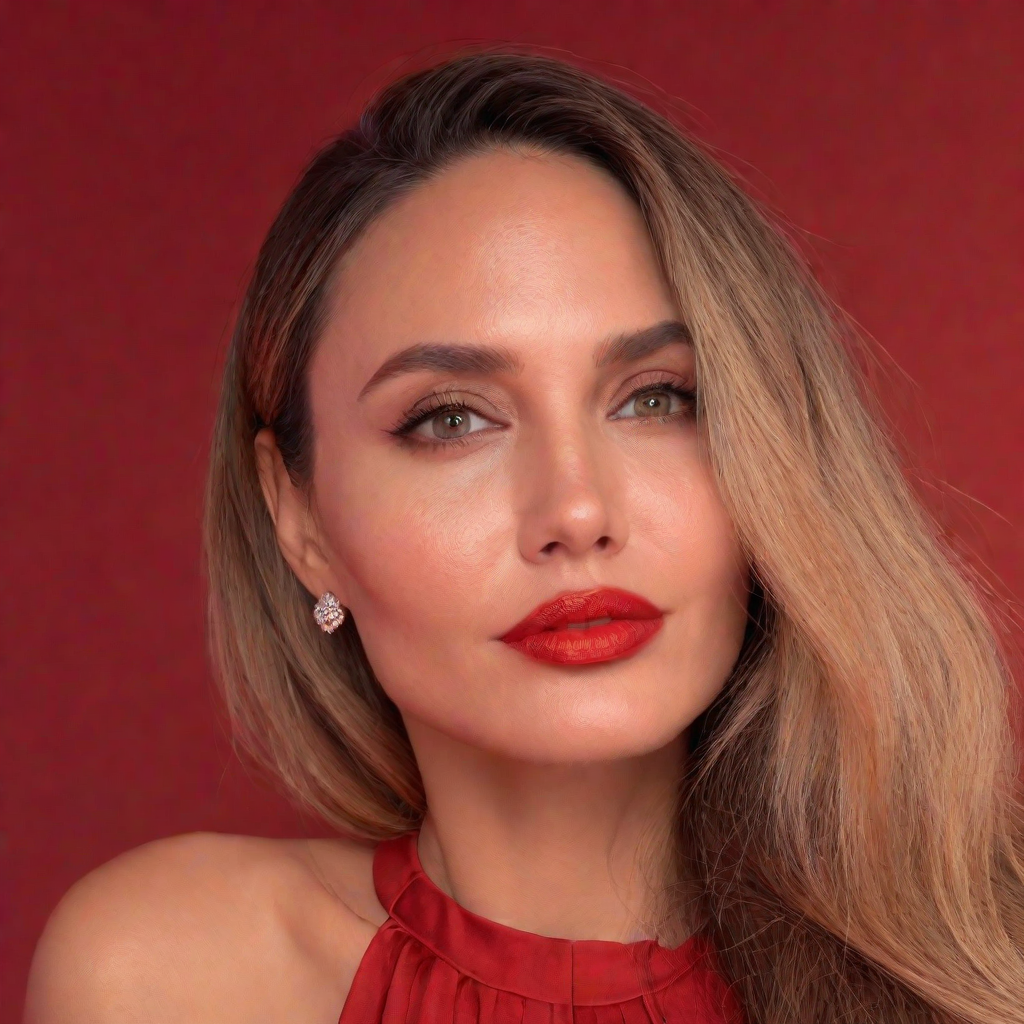

In [6]:
image_path = '/content/drive/My Drive/dataset/exp_9_images/2generated_image_seed_9_2.png'
image = Image.open(image_path)
image